In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
import scipy.stats

In [4]:
'''Load JSON files'''
f = open('../clm-runscripts/logs/saved-data-copy.json')
data = json.load(f)
data_dict = dict(data)

In [5]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[dt1.DATE.dt.year == 2017]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)

In [6]:
'''Convert WTE to WTD'''
wte['WTD'] = -(422.0 - wte.WTE)
wte

,PEATLAND,DATE,WTE,FLAG,WTD
0,S2,2017-01-01,421.92,M,-0.08
1,S2,2017-01-02,421.92,M,-0.08
2,S2,2017-01-03,421.92,M,-0.08
3,S2,2017-01-04,421.92,M,-0.08
4,S2,2017-01-05,421.92,M,-0.08
...,...,...,...,...,...
360,S2,2017-12-27,421.89,M,-0.11
361,S2,2017-12-28,421.87,M,-0.13
362,S2,2017-12-29,421.87,M,-0.13
363,S2,2017-12-30,421.87,M,-0.13


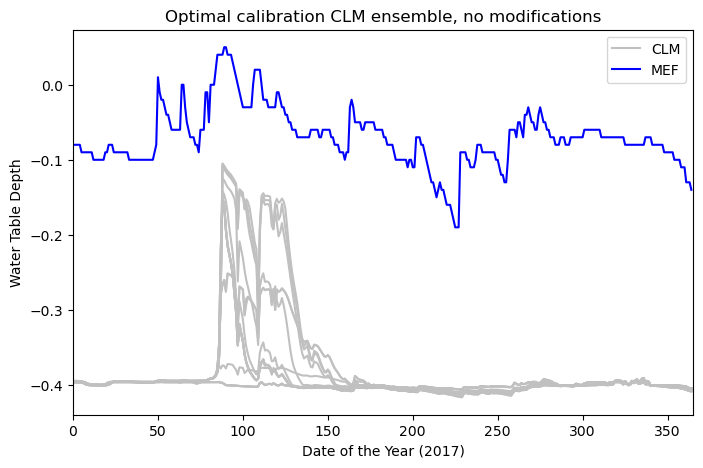

In [7]:
'''Plot model results'''
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

#Plot CLM opt data
for i in range(0, len(data)-1):
    if(i == 0):
        ax.plot(data_dict[str(i)]['data']['timeseries'], color = 'silver', label = 'CLM')
    else:
        ax.plot(data_dict[str(i)]['data']['timeseries'], color = 'silver')

#Plot Marcell data
ax.plot(wte.WTD, color = 'blue', label ='MEF')

#Plot spcifics
ax.set_xlabel('Date of the Year (2017)')
ax.set_ylabel('Water Table Depth')
plt.title('Optimal calibration CLM ensemble, no modifications')
plt.xlim(0, 365)
plt.legend()

In [25]:
#Flatten
clm_wte = [item for sublist in data_dict['1']['data']['timeseries'] for item in sublist]

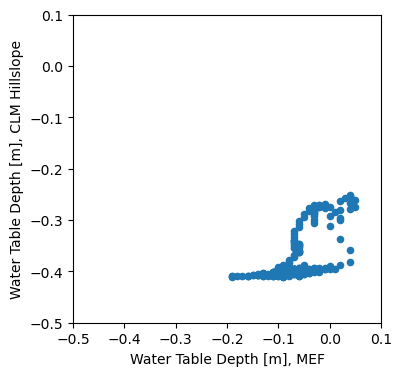

In [29]:
'''Plot model correlation'''
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.scatter(wte.WTD, clm_wte, s = 20)
ax.set_xlabel('Water Table Depth [m], MEF')
ax.set_ylabel('Water Table Depth [m], CLM Hillslope')
ax.set_xlim(-0.50, 0.10)
ax.set_ylim(-0.50, 0.10)
ax.set_aspect('equal', 'box')

In [27]:
'''Correlation'''
result = scipy.stats.linregress(wte.WTD, clm_wte)

In [34]:
result.rvalue*result.rvalue

0.40501328081740995

In [37]:
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

In [38]:
nse(clm_wte, wte.WTD)

-63.16208576695472